In [1]:
%load_ext autoreload
%autoreload 2
import os, sys

sys.path.append(
    os.path.abspath(os.path.join(os.getcwd(), os.pardir, os.pardir))
)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ppi_py.datasets import load_dataset
from ppi_py import ppi_ols_ci, classical_ols_ci
from tqdm import tqdm
from scipy.optimize import brentq
from scipy.special import expit
from tqdm import tqdm

In [2]:
alpha = 0.1
ns = np.linspace(500, 5000, 10).astype(
    int
)  # Test for different numbers of labeled examples
sigmas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 1]
N = 10000
num_trials = 100
d = 2
epsilon = 1
coord = 0

theta_star = np.random.randn(d)
print(theta_star)

[ 0.36525903 -1.39557058]


In [3]:
# Run prediction-powered inference and classical inference for many values of n
results = []
for s in range(len(sigmas)):
    sigma = sigmas[s]
    for j in tqdm(range(num_trials)):
        X = np.random.multivariate_normal(np.zeros(d), np.eye(d), ns.max())
        Y = X @ theta_star + epsilon * np.random.normal(0, 1, ns.max())
        Yhat = Y + sigma * np.random.normal(-2, 1, ns.max())
        X_unlabeled = np.random.multivariate_normal(np.zeros(d), np.eye(d), N)
        Y_unlabeled = X_unlabeled @ theta_star + epsilon * np.random.normal(
            0, 1, N
        )
        Yhat_unlabeled = Y_unlabeled + sigma * np.random.normal(-2, 1, N)
        for i in range(ns.shape[0]):
            n = ns[i]
            _X = X[:n]
            _Y = Y[:n]
            _Yhat = Yhat[:n]

            # PPI interval
            ppi_ci = ppi_ols_ci(
                _X, _Y, _Yhat, X_unlabeled, Yhat_unlabeled, alpha=alpha, lam=1
            )
            classical_ci = classical_ols_ci(
                _X, _Y, alpha=alpha
            )
            ppi_ci_tuned = ppi_ols_ci(
                _X,
                _Y,
                _Yhat,
                X_unlabeled,
                Yhat_unlabeled,
                coord=coord,
                alpha=alpha,
            )
            # Append results
            results += [
                pd.DataFrame(
                    [
                        {
                            "method": "PPI",
                            "n": n,
                            "lower": ppi_ci[0][coord],
                            "upper": ppi_ci[1][coord],
                            "included": (ppi_ci[0][coord] <= theta_star[coord])
                            & (ppi_ci[1][coord] >= theta_star[coord]),
                            "trial": j,
                            "sigma": sigma,
                        }
                    ]
                )
            ]

            results += [
                pd.DataFrame(
                    [
                        {
                            "method": "classical",
                            "n": n,
                            "lower": classical_ci[0][coord],
                            "upper": classical_ci[1][coord],
                            "included": (
                                classical_ci[0][coord] <= theta_star[coord]
                            )
                            & (classical_ci[1][coord] >= theta_star[coord]),
                            "trial": j,
                            "sigma": sigma,
                        }
                    ]
                )
            ]

            results += [
                pd.DataFrame(
                    [
                        {
                            "method": "PPI++",
                            "n": n,
                            "lower": ppi_ci_tuned[0][coord],
                            "upper": ppi_ci_tuned[1][coord],
                            "included": (
                                ppi_ci_tuned[0][coord] <= theta_star[coord]
                            )
                            & (ppi_ci_tuned[1][coord] >= theta_star[coord]),
                            "trial": j,
                            "sigma": sigma,
                        }
                    ]
                )
            ]

df = pd.concat(results, axis=0, ignore_index=True)
df["width"] = df["upper"] - df["lower"]

100%|██████████| 100/100 [02:22<00:00,  1.42s/it]


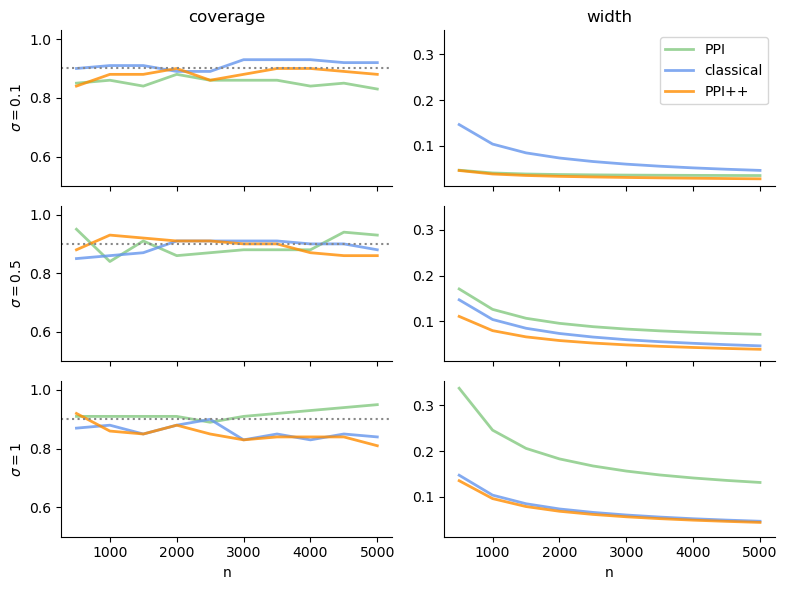

In [4]:
palette = {
    "PPI++": "darkorange",
    "PPI": "#83C980",
    "classical": "cornflowerblue",
}
linewidth = 2
sigmas_to_plot = [sigmas[0], sigmas[-3], sigmas[-1]]
df_to_plot = df[np.isin(df.sigma, sigmas_to_plot)]
n_unique_sigmas = len(sigmas_to_plot)


fig, axs = plt.subplots(
    nrows=n_unique_sigmas,
    ncols=2,
    figsize=(8, 2 * n_unique_sigmas),
    sharex=True,
    sharey="col",
)
for s in range(n_unique_sigmas):
    cvg_ax = axs[s, 0]
    sz_ax = axs[s, 1]
    legend = False if s > 0 else True
    sns.lineplot(
        ax=cvg_ax,
        data=df_to_plot[df_to_plot.sigma == sigmas_to_plot[s]],
        x="n",
        y="included",
        linewidth=linewidth,
        errorbar=None,
        hue="method",
        legend=False,
        palette=palette,
        alpha=0.8,
    )
    sns.lineplot(
        ax=sz_ax,
        data=df_to_plot[df_to_plot.sigma == sigmas_to_plot[s]],
        x="n",
        y="width",
        linewidth=linewidth,
        errorbar=None,
        hue="method",
        legend=legend,
        palette=palette,
        alpha=0.8,
    )
    cvg_ax.set_ylabel(r"$\sigma=$" + str(sigmas_to_plot[s]))
    cvg_ax.set_ylim([0.5, 1.03])
    cvg_ax.axhline(y=1 - alpha, color="#888888", linestyle="dotted")
    cvg_ax.set_xlabel("")
    sz_ax.set_ylabel("")
    sz_ax.set_xlabel("")
    if legend:
        sz_ax.legend_.set_title(None)
axs[0, 0].set_title("coverage")
axs[0, 1].set_title("width")
axs[-1, 0].set_xlabel("n")
axs[-1, 1].set_xlabel("n")
sns.despine(top=True, right=True)
plt.tight_layout()
os.makedirs("./plots", exist_ok=True)
plt.savefig("./plots/tuned-PPI-ols.pdf")